In [1]:
import anndata as ad

In [2]:
adata = ad.read_h5ad("/home/users/kzlin/kzlinlab/projects/veloUncertainty/out/yuhong/data/v4_greenleaf/seed317/scv/adata_glf_scv_total_v4.h5ad")

In [3]:
adata

AnnData object with n_obs × n_vars = 38263 × 2000
    obs: 'Sample.ID', 'Age', 'Tissue.ID', 'Sample.Type', 'Assay', 'Batch', 'seurat_clusters', 'RNA.Counts', 'RNA.Features', 'Percent.MT', 'Percent.Ribo', 'Cell.Barcode', 'DF_pANN', 'DF_classification', 'DF_pANN_quantile', 'Spliced.Counts', 'Spliced.Features', 'Unspliced.Counts', 'Unspliced.Features', 'Ambiguous.Counts', 'Ambiguous.Features', 'cluster_name', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'n_counts', 'velocity_self_transition'
    var: 'indices', 'gene_count_corr', 'means', 'dispersions', 'dispersions_norm', 'highly_variable', 'fit_r2', 'fit_alpha', 'fit_beta', 'fit_gamma', 'fit_t_', 'fit_scaling', 'fit_std_u', 'fit_std_s', 'fit_likelihood', 'fit_u0', 'fit_s0', 'fit_pval_steady', 'fit_steady_u', 'fit_steady_s', 'fit_variance', 'fit_alignment_scaling', 'velocity_genes'
    uns: 'log1p', 'neighbors', 'pca', 'recover_dynamics', 'umap', 'velocity_graph', 'velocity_graph_neg', 'velocity_params'
    obsm: 'X_

In [11]:
adata.var['indices']

0
ENSG00000188290       26
ENSG00000187608       27
ENSG00000188157       29
ENSG00000131584       46
ENSG00000116151       91
                   ...  
ENSG00000160190    32511
ENSG00000142156    32613
ENSG00000160285    32623
ENSG00000215424    32625
ENSG00000160305    32632
Name: indices, Length: 2000, dtype: int64

In [ ]:
adata.uns['velocity_graph']

<38263x38263 sparse matrix of type '<class 'numpy.float32'>'
	with 7175109 stored elements in Compressed Sparse Row format>

In [6]:
adata.uns['velocity_graph'][10:20,0:10].toarray()

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.28727663, 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.       

In [8]:
import numpy as np
import scipy.sparse as sp

# Step 1: Check all values are non-negative
velocity_graph = adata.uns['velocity_graph']

# Since it's sparse, check only the nonzero entries
all_non_negative = (velocity_graph.data >= 0).all()
print(f"All entries non-negative? {all_non_negative}")

# Step 2: Normalize each row to sum to 1
# Calculate row sums
row_sums = np.array(velocity_graph.sum(axis=1)).flatten()

# To avoid division by zero, set zeros to 1 (rows with all zeros will stay all zeros after normalization)
row_sums_safe = np.where(row_sums == 0, 1, row_sums)

# Create a diagonal matrix with 1/row_sum
row_scaling = sp.diags(1.0 / row_sums_safe)

# Multiply: (row scaling) × (original matrix)
velocity_graph_normalized = row_scaling.dot(velocity_graph)

All entries non-negative? True


In [9]:
import pandas as pd

# Load the CSV
csv_path = "/home/users/kzlin/kzlinlab/projects/veloUncertainty/out/yuhong/data/v4_greenleaf/glf_GPC.csv"
gpc_df = pd.read_csv(csv_path)

# Inspect it
print(gpc_df.head())


                ID
0  ENSG00000152583
1  ENSG00000197921
2  ENSG00000101439
3  ENSG00000131095
4  ENSG00000120885


In [ ]:
gpc_genes = gpc_df['ID'].tolist()

# Genes in your AnnData object
adata_genes = adata.var_names.tolist()  # adata.var_names is usually the gene identifiers

# Find overlap: get indices of genes in adata that are also in gpc_genes
# Create a mapping: gene name -> index
gene_to_idx = {gene: idx for idx, gene in enumerate(adata_genes)}

# Find the indices
overlapping_indices = [gene_to_idx[gene] for gene in gpc_genes if gene in gene_to_idx]

print(f"Number of overlapping genes: {len(overlapping_indices)}")
print(overlapping_indices[:10])  # Show first few indices

Number of overlapping genes: 116
[548, 6, 1849, 1758, 1034, 936, 1989, 1291, 1564, 1031]


In [19]:
import numpy as np

def directed_laplacian_score(A, x):
    """
    Compute the directed Laplacian score for a given vector x and adjacency matrix A.
    
    Args:
        A: scipy sparse matrix (n x n), non-negative, possibly asymmetric.
        x: 1D numpy array (length n)
    
    Returns:
        Directed Laplacian score (float)
    """
    # Make sure A is in CSR format for fast row slicing
    A = A.tocsr()
    
    # Precompute x_i^2 and x_j^2 terms
    x_i_squared = A.multiply(x[:, None] ** 2).sum()
    x_j_squared = A.multiply(x[None, :] ** 2).sum()
    x_cross = A.multiply(np.outer(x, x)).sum()
    
    score = x_i_squared + x_j_squared - 2 * x_cross

    # Variance of x
    var_x = np.var(x)

    # Normalize
    if var_x == 0:
        return np.nan  # or raise an error if you prefer
    normalized_score = score / var_x

    return normalized_score


In [20]:
# Suppose velocity_graph_normalized is your matrix (A)
# and you want to compute for one gene's expression vector x

# Pick one gene
gene_idx = overlapping_indices[0]

# Get the gene expression vector x (length = n_obs = 38263)
x = adata[:, gene_idx].X
if sp.issparse(x):
    x = np.array(x.todense()).flatten()
else:
    x = np.array(x).flatten()

# Compute the score
score = directed_laplacian_score(velocity_graph_normalized, x)
print(score)


58329.76985399345


In [16]:
# Calculate percent zeros
percent_zeros = (np.sum(x == 0) / len(x)) * 100
print(f"Percent of zeros: {percent_zeros:.2f}%")

# Quantiles of nonzero entries
x_nonzero = x[x != 0]
quantiles = np.quantile(x_nonzero, [0.25, 0.5, 0.75, 1])

print(f"Quantiles of nonzero entries (25%, 50%, 75%, 100%): {quantiles}")

Percent of zeros: 98.13%
Quantiles of nonzero entries (25%, 50%, 75%, 100%): [0.47686777 0.70754468 1.07664758 3.84556103]


In [21]:
# Preallocate list to store results
scores = []

n_genes = len(overlapping_indices)

for idx, gene_idx in enumerate(overlapping_indices):
    print(f"Working on gene {idx + 1} out of {n_genes}")

    # Get the gene expression vector x
    x = adata[:, gene_idx].X
    if sp.issparse(x):
        x = np.array(x.todense()).flatten()
    else:
        x = np.array(x).flatten()

    # Compute the normalized directed Laplacian score
    score = directed_laplacian_score(velocity_graph_normalized, x)
    scores.append(score)

# Convert to numpy array if you prefer
scores = np.array(scores)

print("Finished computing all scores!")


Working on gene 1 out of 116
Working on gene 2 out of 116
Working on gene 3 out of 116
Working on gene 4 out of 116
Working on gene 5 out of 116
Working on gene 6 out of 116
Working on gene 7 out of 116
Working on gene 8 out of 116
Working on gene 9 out of 116
Working on gene 10 out of 116
Working on gene 11 out of 116
Working on gene 12 out of 116
Working on gene 13 out of 116
Working on gene 14 out of 116
Working on gene 15 out of 116
Working on gene 16 out of 116
Working on gene 17 out of 116
Working on gene 18 out of 116
Working on gene 19 out of 116
Working on gene 20 out of 116
Working on gene 21 out of 116
Working on gene 22 out of 116
Working on gene 23 out of 116
Working on gene 24 out of 116
Working on gene 25 out of 116
Working on gene 26 out of 116
Working on gene 27 out of 116
Working on gene 28 out of 116
Working on gene 29 out of 116
Working on gene 30 out of 116
Working on gene 31 out of 116
Working on gene 32 out of 116
Working on gene 33 out of 116
Working on gene 34 

In [22]:
scores

array([58329.76985399, 43731.30129937, 46339.1028562 , 48038.70647451,
       36227.64179805, 23236.65639653, 44170.11031975, 14308.32732979,
       24993.01293226, 47982.1211546 , 22656.48096692, 46544.91271256,
       60905.15823972, 64596.12147699, 21527.71256854, 30366.54149137,
       41421.45032521, 23109.28285906, 29312.63468751, 47511.76831923,
       58617.34978702, 37897.1981653 , 62717.89878009, 25522.65489921,
       32979.23339367, 31690.80429749, 27412.32817843, 51597.36562652,
       42342.46585952, 40282.87423835, 23659.55331123, 36751.15758815,
       15882.46417299, 27685.27418856, 31669.60931591, 40988.34851648,
       42132.68192101, 42920.63399376, 54430.82896482, 43090.17042194,
       55247.62248478, 50730.19600186, 62565.44070229, 41332.89971976,
       42002.75354847, 29395.93174697, 47023.53115198, 40202.57185947,
       46832.36534405, 60420.60491748, 44563.5878171 , 45992.91121513,
       53478.8742672 , 37778.19768272, 46122.42461772, 54230.04251269,
      

In [23]:
quantiles = np.quantile(scores, [0, 0.25, 0.5, 0.75, 1])

print(f"Quantiles of nonzero entries (0%, 25%, 50%, 75%, 100%): {quantiles}")

Quantiles of nonzero entries (0%, 25%, 50%, 75%, 100%): [14308.32732979 39626.22843593 47259.06184269 55973.81588627
 70166.16477327]


In [ ]:
# Load the CSV
csv_path_2 = "/home/users/kzlin/kzlinlab/projects/veloUncertainty/out/yuhong/data/v4_greenleaf/glf_nGPCblk_genes_ctrl.csv"
nongpc_df = pd.read_csv(csv_path_2)

# Inspect it
print(nongpc_df.head())
print(nongpc_df.shape)


   Unnamed: 0         genes227         genes230         genes233  \
0           0  ENSG00000102181  ENSG00000132874  ENSG00000186166   
1           1  ENSG00000106392  ENSG00000182963  ENSG00000136731   
2           2  ENSG00000235381  ENSG00000211896  ENSG00000237614   
3           3  ENSG00000154079  ENSG00000106819  ENSG00000226542   
4           4  ENSG00000277448  ENSG00000259734  ENSG00000005007   

          genes236         genes239  
0  ENSG00000116793  ENSG00000258017  
1  ENSG00000282917  ENSG00000246308  
2  ENSG00000183624  ENSG00000254102  
3  ENSG00000228379  ENSG00000122862  
4  ENSG00000233695  ENSG00000268797  


In [27]:
# Extract genes from the 'genes227' column
nongpc_genes = nongpc_df['genes227'].tolist()

# Genes in your AnnData object
adata_genes = adata.var_names.tolist()

# Create a mapping: gene name -> index
gene_to_idx = {gene: idx for idx, gene in enumerate(adata_genes)}

# Find overlapping indices
overlapping_indices_nongpc = [gene_to_idx[gene] for gene in nongpc_genes if gene in gene_to_idx]

print(f"Number of overlapping genes (genes227): {len(overlapping_indices_nongpc)}")
print(overlapping_indices_nongpc[:10])  # Show first few indices

Number of overlapping genes (genes227): 82
[1498, 610, 883, 1384, 1947, 1540, 526, 1800, 271, 1687]


In [29]:
# Preallocate list to store results
nongpc_scores = []

n_genes = len(overlapping_indices_nongpc)

for idx, gene_idx in enumerate(overlapping_indices_nongpc):
    print(f"Working on gene {idx + 1} out of {n_genes}")

    # Get the gene expression vector x
    x = adata[:, gene_idx].X
    if sp.issparse(x):
        x = np.array(x.todense()).flatten()
    else:
        x = np.array(x).flatten()

    # Compute the normalized directed Laplacian score
    score = directed_laplacian_score(velocity_graph_normalized, x)
    nongpc_scores.append(score)

# Convert to numpy array if you prefer
nongpc_scores = np.array(nongpc_scores)

print("Finished computing all scores!")


Working on gene 1 out of 82
Working on gene 2 out of 82
Working on gene 3 out of 82
Working on gene 4 out of 82
Working on gene 5 out of 82
Working on gene 6 out of 82
Working on gene 7 out of 82
Working on gene 8 out of 82
Working on gene 9 out of 82
Working on gene 10 out of 82
Working on gene 11 out of 82
Working on gene 12 out of 82
Working on gene 13 out of 82
Working on gene 14 out of 82
Working on gene 15 out of 82
Working on gene 16 out of 82
Working on gene 17 out of 82
Working on gene 18 out of 82
Working on gene 19 out of 82
Working on gene 20 out of 82
Working on gene 21 out of 82
Working on gene 22 out of 82
Working on gene 23 out of 82
Working on gene 24 out of 82
Working on gene 25 out of 82
Working on gene 26 out of 82
Working on gene 27 out of 82
Working on gene 28 out of 82
Working on gene 29 out of 82
Working on gene 30 out of 82
Working on gene 31 out of 82
Working on gene 32 out of 82
Working on gene 33 out of 82
Working on gene 34 out of 82
Working on gene 35 out 

In [30]:
quantiles = np.quantile(nongpc_scores, [0, 0.25, 0.5, 0.75, 1])

print(f"Quantiles of nonzero entries (0%, 25%, 50%, 75%, 100%): {quantiles}")

Quantiles of nonzero entries (0%, 25%, 50%, 75%, 100%): [14999.14573    44963.8553106  53234.28972127 63237.18829739
 77603.81110768]


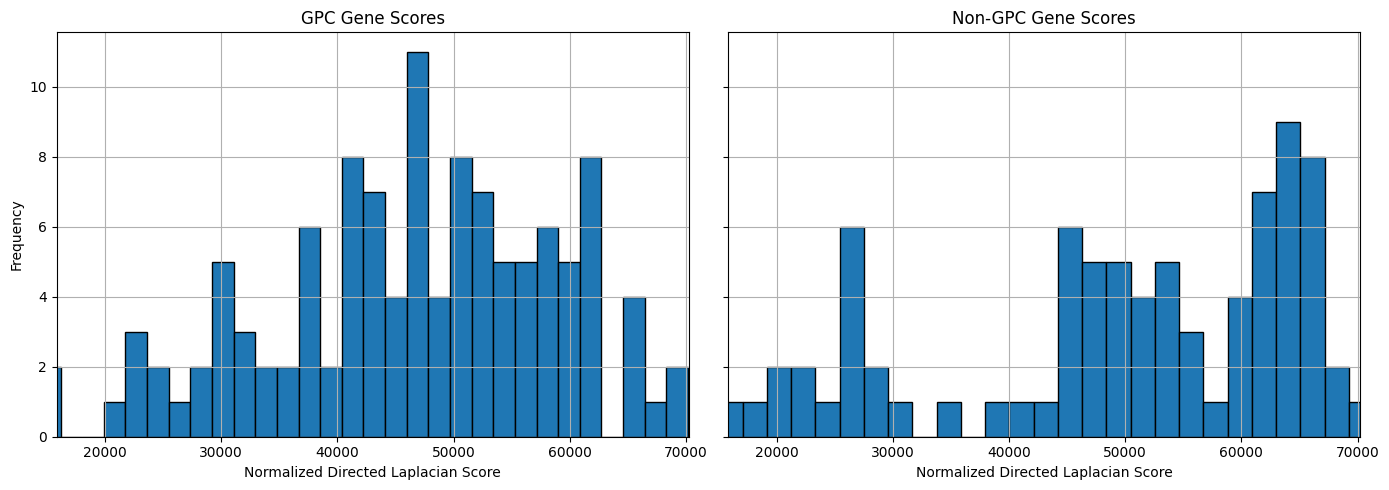

In [32]:
import matplotlib.pyplot as plt
import numpy as np

# Example: assume you have both arrays
# scores = np.array([...])
# nongpc_scores = np.array([...])

# Set up the figure with 2 subplots side-by-side
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)  # sharey=True to use same y-axis scale

# Determine common x-axis limits based on combined data
all_scores = np.concatenate([scores, nongpc_scores])
x_min, x_max = np.percentile(all_scores, [1, 99])  # Clip extreme outliers for better visualization

# Plot histogram for scores (GPC genes)
axes[0].hist(scores, bins=30, edgecolor='black')
axes[0].set_title('GPC Gene Scores')
axes[0].set_xlabel('Normalized Directed Laplacian Score')
axes[0].set_ylabel('Frequency')
axes[0].set_xlim(x_min, x_max)
axes[0].grid(True)

# Plot histogram for nongpc_scores (non-GPC genes)
axes[1].hist(nongpc_scores, bins=30, edgecolor='black')
axes[1].set_title('Non-GPC Gene Scores')
axes[1].set_xlabel('Normalized Directed Laplacian Score')
axes[1].set_xlim(x_min, x_max)
axes[1].grid(True)

plt.tight_layout()
plt.show()
